<h1>Structural Time Series Model with TV State Intervention Data Simulation</h1>

In [1]:
import numpy as np
from scipy.signal import lfilter
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)
import sympy as sym
import pandas as pd
import seaborn as sns
import math
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline



In [90]:
# Construct the model
class localtrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, x_t):
        k_posdef = 2
        exog = x_t
        nobs = x_t.shape[0]
        # Initialize the state space model
        super(localtrend, self).__init__(endog, exog = exog, k_states=2, k_posdef=2,
                                  initialization='diffuse',
                                        loglikelihood_burn=2)

        # Setup the fixed components of the state space representation
        self['design'] = np.r_[1,0]
        self.ssm['transition'] = np.zeros([self.k_states, self.k_states, nobs])
        self.ssm['transition',0,0,:] = 1
        self.ssm['transition',1,1,:] = 1
        self.ssm['transition',0,1,:] = exog
        #self.ssm['transition',2,2,:] = exog
        self['selection'] = np.eye(self.k_states,k_posdef)
        
        self.positive_parameters = slice(0,3)

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(localtrend, self).update(params, transformed, **kwargs)

        self['obs_cov', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[1]
        self['state_cov', 1, 1] = params[2]
        

    @property
    def start_params(self):
        return [np.std(self.endog)]*3
    
    @property
    def param_names(self):
        return ['epsilon','xi','zeta']
    
    def transform_params(self, unconstrained):
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = (
            constrained[self.positive_parameters] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = (
            unconstrained[self.positive_parameters] ** 0.5
        )
        return unconstrained

<li>Local Linear Trend Model<ol>
    <li>Sigma: variance of noise</li>
    <li>Epsilon: disturbance</li>
    <li>Xi: error </li>
    </ol>
</li>
<br>
    
\begin{equation*}
y_{t} = {\mu}_t + \epsilon_t  \quad\epsilon_t \sim N(0,\sigma_{\epsilon}^2)\\
\mu_{t+1} = {\mu}_t + \beta_t x_t +\xi_t \quad\xi_t \sim N(0,\sigma_{\xi}^2)\\
\beta_{t+1} = \beta_t + \zeta_t \quad\zeta_t \sim N(0,\sigma_{\zeta}^2)\\
\end{equation*}

State Space Representation:
\begin{equation*}
y_{t} = \begin{vmatrix}
1 & 0 
\end{vmatrix} \begin{pmatrix}
\mu_t \\
\beta_t
\end{pmatrix} + \epsilon_t\\
\begin{pmatrix}
\mu_t \\
\beta_t
\end{pmatrix}= \begin{vmatrix}
1 & x_t \\
0 & 1
\end{vmatrix} \begin{pmatrix}
\mu_t \\
\beta_t
\end{pmatrix} + \begin{pmatrix}
\xi_t \\
\zeta_t
\end{pmatrix}
\end{equation*}


In [102]:
# True model parameters
nobs = int(1e5)
true_epsilon = 9
true_xi = 4
true_zeta = 3


In [103]:
# Simulate a time series
np.random.seed(1234)
disturbances_xi = np.random.normal(0, math.sqrt(true_xi), size=(nobs,))
#x_t = np.random.normal(3, math.sqrt(x_var), size=(nobs,))
cycle = [np.linspace(-np.pi, np.pi-np.pi/25, 50)] * 2000
x_t_ang = np.reshape(np.array(cycle), 100000)
x_t = np.sin(x_t_ang)
#x_t = np.linspace(0,3,nobs)
true_beta = np.cumsum(np.random.normal(0, math.sqrt(true_zeta), size=(nobs,)))
intervention = x_t*true_beta
mut = lfilter([1], np.r_[1, -1], disturbances_xi+intervention)
disturbances_epsilon = np.random.normal(0, math.sqrt(true_epsilon), size=(nobs,))

yt = mut + disturbances_epsilon 


In [104]:
mod = localtrend(yt, x_t)
res = mod.fit()
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.71216D+00    |proj g|=  9.36777D-03


 This problem is unconstrained.



At iterate    5    f=  4.91259D+00    |proj g|=  2.33081D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     17      1     0     0   7.742D-06   4.908D+00
  F =   4.9077264750773155     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/theok/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:2295: UserWarning: Care should be used when applying a loglikelihood burn to a model with exact diffuse initialization. Some results objects, e.g. degrees of freedom, expect only one of the two to be set.
  warnings.warn('Care should be used when applying a loglikelihood'


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:               100000
Model:                     localtrend   Log Likelihood             -490772.648
Date:                Mon, 13 Feb 2023   AIC                         981555.295
Time:                        21:13:50   BIC                         981602.860
Sample:                             0   HQIC                        981569.730
                             - 100000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
epsilon     9.297e-06      2.226   4.18e-06      1.000      -4.364       4.364
xi           658.8226      2.333    282.406      0.000     654.250     663.395
zeta         378.4992      4.999     75.714      0.0

In [105]:
res.smoothed_state[1].mean()

-361.13768408722444

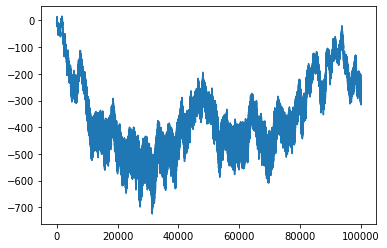

In [106]:
plt.plot(res.smoothed_state[1])

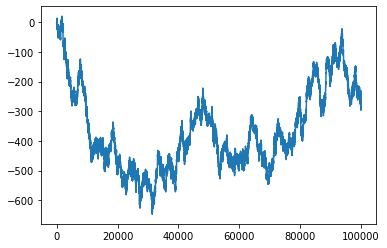

In [107]:
plt.plot(true_beta)